In [42]:
import argparse
import numpy as np
import os
from math import log10, floor
from datetime import datetime
from glob import glob
import stat
import pickle
import math
import array
import scipy
from multiprocessing import Pool
from itertools import repeat
from pathlib import Path
from scipy.signal import correlate
from scipy.fft import ifft, fft, next_fast_len
import qetpy as qp
import matplotlib
import matplotlib.pyplot as plt
import pytesdaq.io.hdf5 as h5io
import pytesdaq
from detprocess.core import OptimumFilterTrigger, EventBuilder, Template, Noise
from detanalysis import PhotonCalibration
from pprint import pprint
from scipy import stats, signal, interpolate, special, integrate
# ignore warnings
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import types
import mendeleev
import pickle as pkl
import sys
from darklim import constants


## Below is the original salting function written by Xinran for the old processing code that was once in pytesdaq. Now the processing code is in detprocess and is compeltely different. The goal is to slowly morph the following cell into an up to date and integratable version for the modern infrastructure

### The function _sim_inject_single_trace was called when the _acquire_trigger function was called with the proper arguments

In [2]:
#lets read in some continuous data from pyle lab run 44
# Instantiate raw data reader
channels = ['Mv3025pcBigFins','Mv3025pcRegular']
continuous_data_path = '/sdata1/runs/run46/raw/continuous_I2_D20240620_T165135'
continuous_data_series = 'I2_D20240620_T165258'
h5 = h5io.H5Reader()
h5.set_files(continuous_data_path, series=continuous_data_series)
mtraces, mtraces_info = h5.read_many_events(nevents=7, detector_chans=channels, include_metadata=True, adctoamp=True)

INFO: Found total of 3 raw data file(s) from 1 different series number!
INFO: Found total of 3 files from 1 different series number!
INFO Node #1: Acquiring randoms for series I2_D20240620_T165258
INFO: Randoms acquisition done!
INFO: Processing PSD for channel Mv3025pcBigFins
INFO: 930 events found in raw data for channel(s) Mv3025pcBigFins
INFO: Number of events after cuts = 277, efficiency = 29.78%
INFO: Processing PSD for channel Mv3025pcRegular
INFO: 930 events found in raw data for channel(s) Mv3025pcRegular
INFO: Number of events after cuts = 184, efficiency = 19.78%


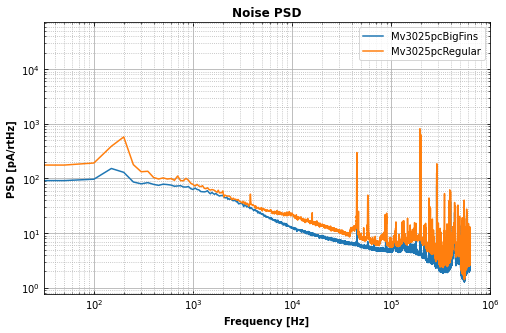

In [3]:
noise = Noise(verbose=True)
noise.generate_randoms(continuous_data_path, series=continuous_data_series, 
                       nevents=1000, min_separation_msec=100, ncores=1)
trace_length_msec = 20
pretrigger_length_msec = 10


# calculate PSD
noise.calc_psd(channels,
               nevents=1000,
               trace_length_msec=trace_length_msec, 
               pretrigger_length_msec=pretrigger_length_msec)

# displays
noise.plot_psd(channels)

# get values
psd_Mv3025pcBigFins, psd_freq = noise.get_psd('Mv3025pcBigFins')
psd_Mv3025pcRegular, psd_freq = noise.get_psd('Mv3025pcRegular')
fs = noise.get_sample_rate()

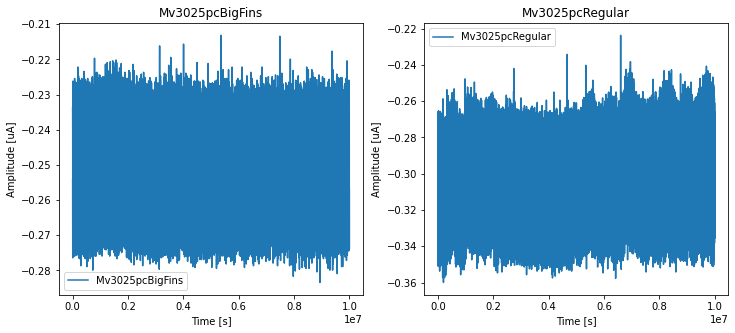

In [4]:
# let's select an event
traces = mtraces[3]
info = mtraces_info[3]
fs = info['sample_rate']
dt = 1/fs
bins = np.asarray(list(range(traces.shape[-1])))*dt*1e6

# display
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
for it in range(len(channels)):
    ax[it].plot(bins, traces[it,:]*1e6, label=channels[it])
    ax[it].legend()
    ax[it].set_title(channels[it])
    ax[it].set_xlabel("Time [s]")
    ax[it].set_ylabel("Amplitude [uA]")

In [5]:
info

{'event_id': 4,
 'event_index': 4,
 'event_num': 100004,
 'event_time': 1718927620,
 'comment': 'laser off ',
 'daq_version': '1.0.0',
 'data_prefix': 'cont',
 'data_purpose': 'Test',
 'dump_num': 1,
 'facility': 2,
 'format_version': '1.0.0',
 'fridge_run': 46,
 'fridge_run_start': 1718636400,
 'group_comment': '"laser off"',
 'group_name': 'continuous_I2_D20240620_T165135',
 'group_start': 1718927496,
 'prefix': '/sdata/runs/run46/raw/continuous_I2_D20240620_T165135/cont',
 'restricted': 0,
 'run_purpose': 'Test',
 'run_type': 'Test',
 'series_num': 220240620165258,
 'series_start': 1718927578,
 'timestamp': 1718927578,
 'adc_channel_indices': [2, 3],
 'adc_conversion_factor': array([[-2.1768620e-03,  1.5620886e-04,  1.8947182e-14,  1.9860906e-18],
        [ 8.3860796e-04,  1.5626207e-04,  1.2102963e-14,  1.1442504e-18]],
       dtype=float32),
 'connection0': array(['detector:Mv3TESs4pc', 'tes:A', 'controller:feb1_A'], dtype='<U19'),
 'connection1': array(['detector:Mv3TESs800x200',

Calculating dPdI! This may take some time.


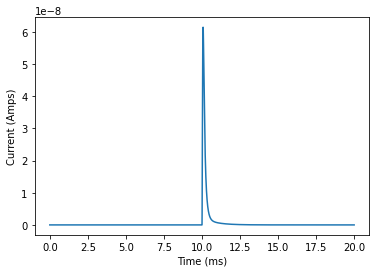

Calculating dPdI! This may take some time.


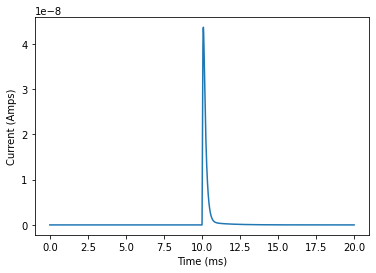

In [6]:
with open("/sdata1/runs/run46/processed/didvs/didvresult_Mv3025pcBigFins_0624", 'rb') as handle:
    didv_bigfins = pickle.load(handle)
    
with open("/sdata1/runs/run46/processed/didvs/didvresult_Mv3025pcRegular_0624", 'rb') as handle:
    didv_regfins = pickle.load(handle)
    
    #phonon veto calibration object
with open("/sdata1/runs/run46/processed/photon_calibrations/photoncal_025pcBigFins_062624_405", 'rb') as handle:
    cal_bigfins = pickle.load(handle)
    
#tes calibration object
with open("/sdata1/runs/run46/processed/photon_calibrations/photoncal_025pcRegular_062624_405", 'rb') as handle:
    cal_regfins = pickle.load(handle)
    
    
t_arr = np.arange(0, 20e-3 - 0.5/(1.25e6),
                  1/(1.25e6))
start_time = 10e-3

template_big, time_array = cal_bigfins.get_current_template(2, didv_bigfins, t_arr, start_time=start_time)

template_reg, time_array = cal_regfins.get_current_template(2, didv_regfins, t_arr, start_time=start_time)

In [7]:
pretrigger_length_msec = 10
pretrigger_sample = int(pretrigger_length_msec*1e-3*fs)

OF_Mv3025pcBigFins = OptimumFilterTrigger(channels[0], fs,template_big, 
                                        psd_Mv3025pcBigFins,pretrigger_sample)
OF_Mv3025pcRegular = OptimumFilterTrigger(channels[1], fs,template_reg, 
                                        psd_Mv3025pcRegular,pretrigger_sample)

In [8]:
res = OF_Mv3025pcBigFins.get_resolution()

In [9]:
res

0.04871744496649507

In [10]:
OF_Mv3025pcBigFins.update_trace(traces[0,:])
OF_Mv3025pcRegular.update_trace(traces[1,:])

In [11]:
filtered_trace = np.zeros_like(traces)
filtered_trace[0,:] = OF_Mv3025pcBigFins._filtered_trace
filtered_trace[1,:] = OF_Mv3025pcRegular._filtered_trace

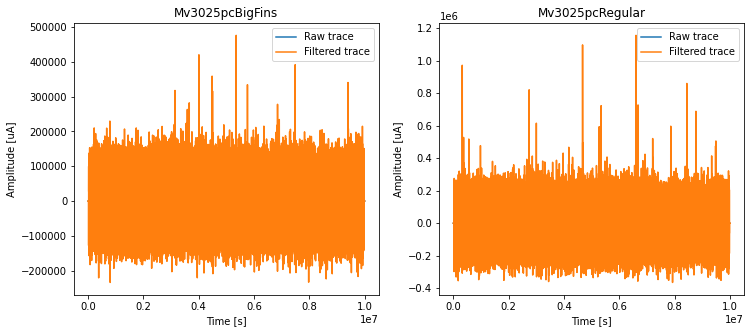

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
for it in range(len(channels)):
    ax[it].plot(bins, traces[it]*1e6, label='Raw trace')
    ax[it].plot(bins, filtered_trace[it,:]*1e6, label='Filtered trace')
    ax[it].legend()
    ax[it].set_title(channels[it])
    ax[it].set_xlabel("Time [s]")
    ax[it].set_ylabel("Amplitude [uA]")

In [13]:
sim_energies=[0.5,0.3]
nsim = 10
coincident_window = 500e-6

In [18]:
def _sim_inject_single_trace(self, trace, filteredTrace, nsim, energies, traces_norm, TES_energy_scale, coincident_window, usetemplate=False, pulses=None):
        """
        trace is 2d array: #channels, #bins
        """
        #inject simulated pulse to trace! energies in eV
        newtrace = np.array(trace,copy=True) #make an exact copy of the original input trace
        newfilteredTrace = np.array(filteredTrace, copy=True) #make a copy of the trace as returned from the OF
        salts_before_ADC=np.zeros(trace.shape,dtype=float) #make an array the same length as the trace. Here is where we will inject the salt
        salts_filtered  =np.zeros(trace.shape,dtype=float) #make an array the same length as the trace. This is where we put the salts after they are filtered
        #random times
        if pulses is not None: #pulses is an array Nd array where N is number of pulses and each "pulse" array is a trace with a pulse(?)
            if len(pulses)!=nsim :
                raise ValueError('ERROR: unexpected slats vector length!')
            simTime = np.transpose(pulses)[0].astype(int)
            energy = np.transpose(pulses)[1]
        else:
            simTime = np.random.rand(nsim) #randomly select a time between 0 and 1 to place the salt
            #scale to the total trace length, leave coincident_window samples margin to the end.
            coincident_window_bin=int(coincident_window*self._sample_rate)+1 #take the coincident_window in units of us and convert it to n samples
            simTime *= trace[0].size - self._nb_samples*2 - coincident_window_bin - coincident_window_bin*nsim # take that simTime and scale it to trace length -???
            #offset adjacent salts with coincident_window_bin samples, such that when matching trigger time to sim truth the salts do not mix.
            simTime = np.sort(simTime) + np.arange(nsim)*coincident_window_bin 
            simTime = simTime.astype(int)
            simTime += self._nb_samples//2
            #Sample energy in eV,
            energy = np.random.choice(energies,nsim)

        simAmp = []
        for ichan in range(trace.shape[0]) :
            if ichan>0 :
                print("Warning! Salting for multichannel not implemented!")
            else :
                #prepare pulse shape, use the filter template by default.
                template = self._filter_dict['template'][ichan] #this is the template you give the OF
                filttemplate = self._filter_dict['filttemplate'][ichan] #this is the template after the OF???

                #if usetemplate or True :
                #else :
                #    #construct pulse shape with rise and fall times.
                #    print("to be implemented")

                # scale to Amp
                if traces_norm is None : #what norm is this? Norm of the OF amp? adc to miliamp
                    template_amp = template
                else :
                    p = np.poly1d(traces_norm[ichan]) #FIXME!! for multiple channels, norm is an array of triggering channels, not all channels.
                    template_amp = p(template+newtrace[ichan][0]) #normalize the template pulse+actual trace values
                    template_amp -= template_amp[0] #subtract the baseline
                template_amp_amplitude = max(template_amp) #take the largest amplitude from the trace and call it the amplitude
                # scale to the sim energy
                vb_corr=TES_energy_scale['TES_vb']-2*TES_energy_scale['TES_i0']*TES_energy_scale['TES_rl']
                rl=TES_energy_scale['TES_rl']
                e_init = np.trapz(template_amp*vb_corr - template_amp*template_amp*rl, dx=1./self._sample_rate) * 6.242e18 # convert to energy

                for isim, amplitude_e in enumerate(energy* TES_energy_scale['detector_eff']):#detector_eff = PCE
                    template_scaled = (template/e_init * amplitude_e) #.astype(int) #DO digitization in the end!
                    filttemplate_scaled = filttemplate * energy[isim] 
                    simAmp.append(template_amp_amplitude/e_init * amplitude_e)
                    if self._is_negative_pulse:
                        template_scaled *= -1
                        filttemplate_scaled *= -1
                    ## offset to the sampled time
                    salts_before_ADC[ichan,simTime[isim]:simTime[isim]+self._nb_samples] += template_scaled
                    salts_filtered  [ichan,simTime[isim]-self._nb_samples//2+1:simTime[isim]+self._nb_samples+self._nb_samples//2] += filttemplate_scaled
        #simulate the digitization: randomize the digits of each sample of the salt
        salts_after_ADC=np.floor(salts_before_ADC).astype(int)
        newtrace += salts_after_ADC
        newtrace += (salts_before_ADC-salts_after_ADC-np.random.random_sample(trace.shape))>0
        newfilteredTrace += salts_filtered
        simPulses = np.transpose([simTime,energy,simAmp])
        return newtrace, newfilteredTrace, simPulses

In [19]:

def _sim_inject_single_trace(trace,metadata,time_array, OF, nsim, energies, didv_result,template, coincident_window, usetemplate=False, pulses=None):
        """
        trace is 2d array: #channels, #bins
        """
        #inject simulated pulse to trace! energies in eV
        newtrace = np.array(trace,copy=True)
        OF.update_trace(trace[0])
        filtered_trace = np.zeros_like(trace)
        filtered_trace[0] = OF._filtered_trace
        newfilteredTrace = np.array(filtered_trace, copy=True)
        salts_before_ADC=np.zeros(trace.shape,dtype=float)
        salts_filtered  =np.zeros(trace.shape,dtype=float)
        nb_samples=len(template)
        #random times
        if pulses is not None:
            if len(pulses)!=nsim :
                raise ValueError('ERROR: unexpected slats vector length!')
            simTime = np.transpose(pulses)[0].astype(int)
            energy = np.transpose(pulses)[1]
        else:
            simTime = np.random.rand(nsim)
            #scale to the total trace length, leave coincident_window samples margin to the end.
            coincident_window_bin=int(coincident_window*info['sample_rate'])+1
            simTime *= trace[0].size - nb_samples*2 - coincident_window_bin - coincident_window_bin*nsim
            #offset adjacent salts with coincident_window_bin samples, such that when matching trigger time to sim truth the salts do not mix.
            simTime = np.sort(simTime) + np.arange(nsim)*coincident_window_bin 
            simTime = simTime.astype(int)
            simTime += nb_samples//2
            #Sample energy in eV,
            energy = np.random.choice(energies,nsim)

        simAmp = []
        for ichan in range(trace.shape[0]) :
            if ichan>0 :
                print("Warning! Salting for multichannel not implemented!")
            else :
                #prepare pulse shape, use the filter template by default.
                #template = self._filter_dict['template'][ichan]
                #filttemplate = self._filter_dict['filttemplate'][ichan]
                template = template
                filttemplate = correlate(template,OF.get_phi(),mode="full",method='fft')/OF.get_norm()

                #if usetemplate or True :
                #else :
                #    #construct pulse shape with rise and fall times.
                #    print("to be implemented")

                # scale to Amp
                p = np.poly1d(metadata['adc_conversion_factor'][0]) 
                template_amp = p(template+newtrace[ichan][0])
                template_amp -= template_amp[0]
                template_amp_amplitude = max(template_amp)
                # scale to the sim energy
                vb_corr=(didv_result['biasparams']['ibias']*didv_result['biasparams']['rsh'])-2*didv_result['biasparams']['i0']*didv_result['biasparams']['rl']
                rl=didv_result['biasparams']['rl']
                e_init = qp.get_energy_normalization(time_array, template, didv_result=didv_bigfins, lgc_ev=True)
                #e_init = np.trapz(template_amp*vb_corr - template_amp*template_amp*rl, dx=1./self._sample_rate) * 6.242e18 #FIXME!! Hard coded number!
                resolution = OF.get_resolution()

                for isim, amplitude_e in enumerate(energy* 0.5):
                    template_scaled = (template/e_init * amplitude_e) #.astype(int) #DO digitization in the end!
                    filttemplate_scaled = filttemplate * energy[isim] 
                    simAmp.append(template_amp_amplitude/e_init * amplitude_e)
                    #if self._is_negative_pulse:
                    #    template_scaled *= -1
                    #    filttemplate_scaled *= -1
                    ## offset to the sampled time
                    salts_before_ADC[ichan,simTime[isim]:simTime[isim]+nb_samples] += template_scaled
                    salts_filtered  [ichan,simTime[isim]-nb_samples//2+1:simTime[isim]+nb_samples+nb_samples//2] += filttemplate_scaled
        #simulate the digitization: randomize the digits of each sample of the salt
        salts_after_ADC=np.floor(salts_before_ADC).astype(int)
        newtrace += salts_after_ADC
        newtrace += (salts_before_ADC-salts_after_ADC-np.random.random_sample(trace.shape))>0
        newfilteredTrace += salts_filtered
        simPulses = np.transpose([simTime,energy,simAmp])
        return newtrace, newfilteredTrace, simPulses

In [20]:
traces_norm = [1e-6,1e-6]

In [21]:
newtrace,newfilteredTrace, simPulses = _sim_inject_single_trace(trace,info,time_array, OF_melange25pc1ch, nsim, sim_energies, didv_bigfins,template_big, coincident_window, usetemplate=False, pulses=None)

In [22]:
newtrace

array([[-2.54166937e-07, -2.55416608e-07, -2.54416871e-07, ...,
        -2.59165621e-07, -2.52167463e-07, -2.56916213e-07]])

No handles with labels found to put in legend.


Text(0, 0.5, 'Amplitude [uA]')

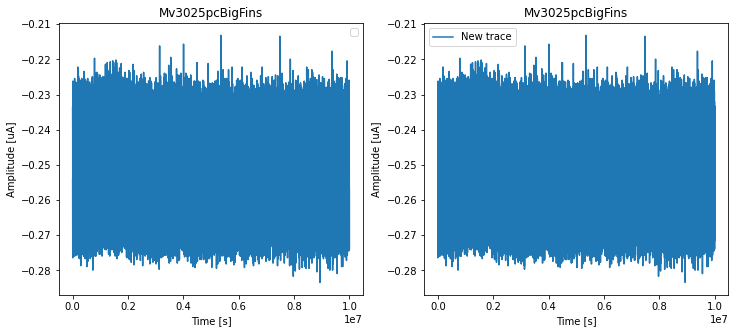

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
ax[0].legend()
ax[0].set_title(channels[0])
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Amplitude [uA]")
ax[0].plot(bins, trace[0,:]*1e6, label='Raw trace')
ax[1].plot(bins, newtrace[0,:]*1e6, label='New trace')
ax[1].legend()
ax[1].set_title(channels[0])
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Amplitude [uA]")

No handles with labels found to put in legend.


Text(0, 0.5, 'Amplitude [uA]')

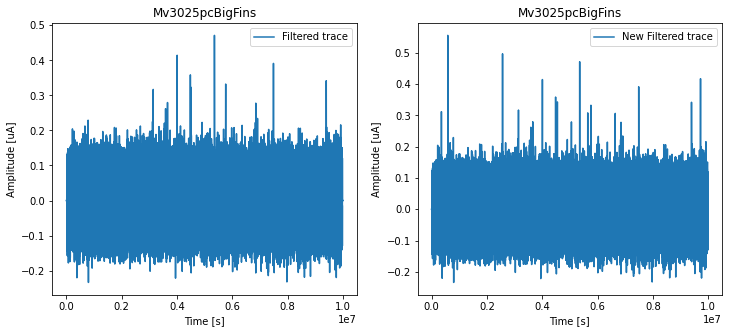

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
ax[0].legend()
ax[0].set_title(channels[0])
ax[0].set_xlabel("Time [s]")
ax[0].set_ylabel("Amplitude [uA]")
ax[0].plot(bins, filtered_trace[0,:], label='Filtered trace')
ax[0].legend()
ax[1].plot(bins, newfilteredTrace[0,:], label='New Filtered trace')
ax[1].legend()
ax[1].set_title(channels[0])
ax[1].set_xlabel("Time [s]")
ax[1].set_ylabel("Amplitude [uA]")

## Now make the salting work for two channels, in the most simple way

In [14]:
ofarray = [OF_Mv3025pcBigFins,OF_Mv3025pcRegular]
templatearray = [template_big,template_reg]
didvarray = [didv_bigfins,didv_regfins]
PCEarray=[0.4,0.3]

In [15]:
ofarray[0]

In [16]:
testing = ofarray[0].get_resolution()
print(testing)

0.04871744496649507


In [17]:

def _sim_inject_single_trace(trace,metadata,time_array, OF,PCE, nsim, energies, didv_result,templates, coincident_window, usetemplate=False, pulses=None):
        """
        trace is 2d array: #channels, #bins
        """
        #inject simulated pulse to trace! energies in eV
        newtrace = np.array(trace,copy=True)
        filtered_trace = np.zeros_like(trace)
        salts_before_ADC=np.zeros(trace.shape,dtype=float)
        salts_filtered  =np.zeros(trace.shape,dtype=float)
        nb_samples=len(templates[0])
        #random times
        if pulses is not None:
            if len(pulses)!=nsim :
                raise ValueError('ERROR: unexpected slats vector length!')
            simTime = np.transpose(pulses)[0].astype(int)
            energy = np.transpose(pulses)[1]
        else:
            simTime = np.random.rand(nsim)
            #scale to the total trace length, leave coincident_window samples margin to the end.
            coincident_window_bin=int(coincident_window*info['sample_rate'])+1
            simTime *= trace[0].size - nb_samples*2 - coincident_window_bin - coincident_window_bin*nsim
            #offset adjacent salts with coincident_window_bin samples, such that when matching trigger time to sim truth the salts do not mix.
            simTime = np.sort(simTime) + np.arange(nsim)*coincident_window_bin 
            simTime = simTime.astype(int)
            simTime += nb_samples//2
            #Sample energy in eV,
            energy = np.random.choice(energies,nsim)

        simAmp = []
        for ichan in range(trace.shape[0]) :
            print("TESTING MULTCHANNEL SALT")
            print(ichan)
            #prepare pulse shape, use the filter template by default.
            #template = self._filter_dict['template'][ichan]
            #filttemplate = self._filter_dict['filttemplate'][ichan]
            optimumfilter=OF[ichan]
            optimumfilter.update_trace(trace[ichan,:])
            filtered_trace[ichan,:] = optimumfilter._filtered_trace
            newfilteredTrace = np.array(filtered_trace, copy=True)
            template = templates[ichan]
            print(len(template))
            print(len(optimumfilter.get_phi()))
            filttemplate = correlate(template,optimumfilter.get_phi(),mode="full",method='fft')/optimumfilter.get_norm() #replace!!!

            #if usetemplate or True :
            #else :
            #    #construct pulse shape with rise and fall times.
            #    print("to be implemented")

            # scale to Amp
            p = np.poly1d(metadata['adc_conversion_factor'][0]) 
            template_amp = p(template+newtrace[ichan][0])
            template_amp -= template_amp[0]
            template_amp_amplitude = max(template_amp)
            # scale to the sim energy
            e_init = qp.get_energy_normalization(time_array, template, didv_result=didv_result[ichan], lgc_ev=True)
            

            for isim, amplitude_e in enumerate(energy* PCE[ichan]):
                print("starting for loop...")
                print(len(filttemplate))
                template_scaled = (template[ichan]/e_init * amplitude_e) #.astype(int) #DO digitization in the end!
                filttemplate_scaled = filttemplate * energy[isim] 
                simAmp.append(template_amp_amplitude/e_init * amplitude_e)
                #if self._is_negative_pulse:
                #    template_scaled *= -1
                #    filttemplate_scaled *= -1
                ## offset to the sampled time
                salts_before_ADC[ichan,simTime[isim]:simTime[isim]+nb_samples] += template_scaled
                salts_filtered[ichan,simTime[isim]-nb_samples//2+1:simTime[isim]+nb_samples+nb_samples//2] += filttemplate_scaled
        #simulate the digitization: randomize the digits of each sample of the salt
        salts_after_ADC=np.floor(salts_before_ADC).astype(int)
        newtrace += salts_after_ADC
        newtrace += (salts_before_ADC-salts_after_ADC-np.random.random_sample(trace.shape))>0
        newfilteredTrace += salts_filtered
        simPulses = np.transpose([simTime,energy,simAmp])
        return newtrace, newfilteredTrace, simPulses

In [18]:
newtrace,newfilteredTrace, simPulses = _sim_inject_single_trace(traces,info,time_array, ofarray,PCEarray, nsim, sim_energies, didvarray,templatearray, coincident_window, usetemplate=False, pulses=None)

TESTING MULTCHANNEL SALT
0
25000
25000
starting for loop...
49999
starting for loop...
49999
starting for loop...
49999
starting for loop...
49999
starting for loop...
49999
starting for loop...
49999
starting for loop...
49999
starting for loop...
49999
starting for loop...
49999
starting for loop...
49999
TESTING MULTCHANNEL SALT
1
25000
25000
starting for loop...
49999
starting for loop...
49999
starting for loop...
49999
starting for loop...
49999
starting for loop...
49999
starting for loop...
49999
starting for loop...
49999
starting for loop...
49999
starting for loop...
49999
starting for loop...
49999


No handles with labels found to put in legend.


No handles with labels found to put in legend.


Text(0, 0.5, 'Amplitude [uA]')

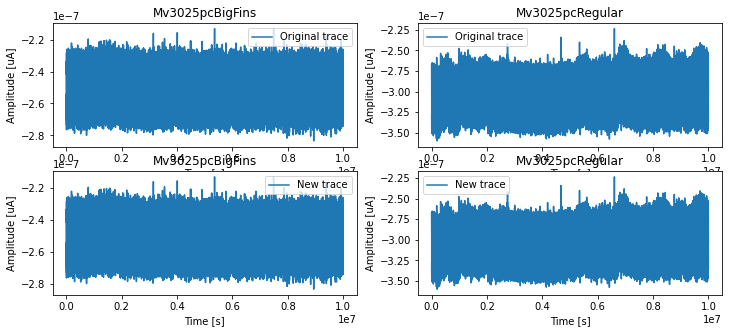

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,5))
ax[0,0].legend()
ax[0,0].set_title(channels[0])
ax[0,0].set_xlabel("Time [s]")
ax[0,0].set_ylabel("Amplitude [uA]")
ax[0,0].plot(bins, traces[0,:], label='Original trace')
ax[0,0].legend()
ax[1,0].plot(bins, newtrace[0,:], label='New trace')
ax[1,0].legend()
ax[1,0].set_title(channels[0])
ax[1,0].set_xlabel("Time [s]")
ax[1,0].set_ylabel("Amplitude [uA]")

ax[0,1].legend()
ax[0,1].set_title(channels[1])
ax[0,1].set_xlabel("Time [s]")
ax[0,1].set_ylabel("Amplitude [uA]")
ax[0,1].plot(bins, traces[1,:], label='Original trace')
ax[0,1].legend()
ax[1,1].plot(bins, newtrace[1,:], label='New trace')
ax[1,1].legend()
ax[1,1].set_title(channels[1])
ax[1,1].set_xlabel("Time [s]")
ax[1,1].set_ylabel("Amplitude [uA]")

No handles with labels found to put in legend.


No handles with labels found to put in legend.


Text(0, 0.5, 'Amplitude [uA]')

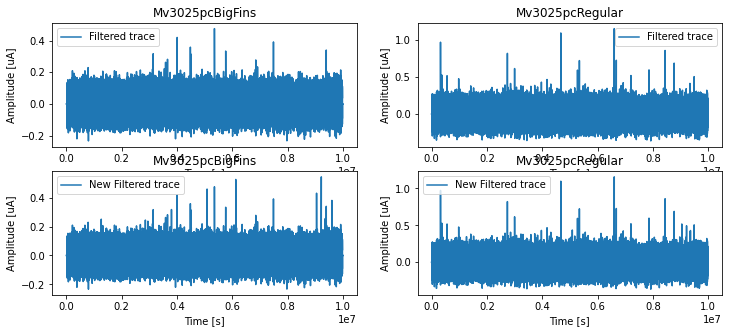

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,5))
ax[0,0].legend()
ax[0,0].set_title(channels[0])
ax[0,0].set_xlabel("Time [s]")
ax[0,0].set_ylabel("Amplitude [uA]")
ax[0,0].plot(bins, filtered_trace[0,:], label='Filtered trace')
ax[0,0].legend()
ax[1,0].plot(bins, newfilteredTrace[0,:], label='New Filtered trace')
ax[1,0].legend()
ax[1,0].set_title(channels[0])
ax[1,0].set_xlabel("Time [s]")
ax[1,0].set_ylabel("Amplitude [uA]")

ax[0,1].legend()
ax[0,1].set_title(channels[1])
ax[0,1].set_xlabel("Time [s]")
ax[0,1].set_ylabel("Amplitude [uA]")
ax[0,1].plot(bins, filtered_trace[1,:], label='Filtered trace')
ax[0,1].legend()
ax[1,1].plot(bins, newfilteredTrace[1,:], label='New Filtered trace')
ax[1,1].legend()
ax[1,1].set_title(channels[1])
ax[1,1].set_xlabel("Time [s]")
ax[1,1].set_ylabel("Amplitude [uA]")

In [21]:
def generate_gaussian_random_numbers(n, mean=0.5, std_dev=0.2):
    while True:
        # Generate random numbers from a Gaussian distribution
        random_numbers = np.random.normal(loc=mean, scale=std_dev, size=n)
        
        # Clip values to be between 0 and 1
        random_numbers = np.clip(random_numbers, 0, 1)
        
        # Check if the sum is positive (important for the normalization step)
        if np.sum(random_numbers) > 0:
            # Normalize to sum to 1
            random_numbers = random_numbers / np.sum(random_numbers)
            return random_numbers

n = 2  # Number of random numbers you want
random_numbers = generate_gaussian_random_numbers(n)
print(random_numbers)
print(f"Sum: {np.sum(random_numbers)}")  # This should print 1

[0.47980151 0.52019849]
Sum: 0.9999999999999999


In [22]:
def pdf_sampling(function, xrange, nsamples=1000, npoints=10000, normalize_cdf=True):
    """
    Produces randomly sampled values based on the arbitrary PDF defined
    by `function`, done using inverse transform sampling.

    Parameters
    ----------
    function : FunctionType
        The 1D probability density function to be randomly sampled from.
    xrange : array_like
        A 1D array of length 2 that defines the range over which the PDF
        in `function` is defined. Outside of this range, it is assumed that
        the PDF is zero.
    nsamples : int, optional
        The number of random samples that we wish to create from the PDF
        defined by `function`.
    npoints : int, optional
        The number of points to use in the numerical integration to evaluate
        the CDF of `function`. This is also the number of points used in the
        interpolation of the inverse of the CDF.
    normalize_cdf : bool, optional
        Boolean value to normalize the CDF or not. If True, the CDF is normalized
        by the PDF area. If False, no normalization is done.

    Returns
    -------
    rvs : ndarray
        The random samples that were taken from the inputted PDF defined by
        `function`. This is a 1D array of length `nsamples`.

    Raises
    ------
    TypeError
        If inputted `function` is not of FunctionType

    Notes
    -----
    For a discussion of inverse transform sampling, see the Wikipedia page:
        https://en.wikipedia.org/wiki/Inverse_transform_sampling

    """

    if not isinstance(function, types.FunctionType):
        raise TypeError("Inputted variable function is not FunctionType.")

    x = np.linspace(xrange[0], xrange[1], num=npoints)
    pdf = function(x)

    cdf = integrate.cumtrapz(pdf, x=x, initial=0.0)

    if normalize_cdf:
        cdf /= cdf[-1]

    inv_cdf = interpolate.interp1d(cdf, x)

    samples = np.random.rand(nsamples)

    return inv_cdf(samples)

In [31]:
def helmfactor(er, tm='Si'):
    """
    The analytic nuclear form factor via the Helm approximation.

    Parameters
    ----------
    er : array_like
        The recoil energy to use in the form factor calculation, units of keV.
    tm : str, int, optional
        The target material of the detector. Can be passed as either the atomic symbol, the
        atomic number, or the full name of the element. Default is 'Si'.

    Returns
    -------
    ffactor2 : ndarray
        The square of the dimensionless form factor for the inputted recoil energies and target
        material.

    Notes
    -----
    This form factor uses Helm's approximation to the charge density of the nucleus, as explained by
    Lewin and Smith in section 4 of their paper:
        - https://doi.org/10.1016/S0927-6505(96)00047-3

    """

    er = np.atleast_1d(er)

    hbarc = constants.hbar * constants.c / constants.e * 1e-6 * 1e15 # [MeV fm]
    mn = constants.atomic_mass * constants.c**2 / constants.e * 1e-9 # 1 amu in [GeV]
    atomic_weight = mendeleev.element(tm).atomic_weight

    # dimensionless momentum transfer
    q = np.sqrt(2 * mn * atomic_weight * er) # [MeV]

    # using the parameters defined in L&S
    s = 0.9 # [fm]
    a = 0.52 # [fm]
    c = 1.23 * atomic_weight**(1 / 3) - 0.60 # [fm]

    # approximation of rn [Eq. 4.11 of L&S]
    rn = np.sqrt(c**2 + 7 / 3 * np.pi**2 * a**2 - 5 * s**2)

    qrn = q * rn / hbarc
    qs = q * s / hbarc

    # Helm approximation of form facter [Eq. 4.7 of L&S]
    ffactor2 = (3 * special.spherical_jn(1, qrn) / qrn * np.exp(-qs**2 / 2))**2 

    return ffactor2

def _mixed_tm(tm):
    """
    Helper function for extracting the element names and number
    of them from an inputted chemical formula.

    """

    pos = [i for i, e in enumerate(tm + 'A') if e.isupper()]
    parts = [tm[pos[j]:pos[j + 1]] for j in range(len(pos) - 1)]
    tms = []
    for item in parts:
        for ii, letter in enumerate(item):
            if letter.isdigit():
                tm_temp = [item[:ii], int(item[ii:])]
                break
            elif ii == len(item) - 1:
                tm_temp = [item, 1]
        tms.append(tm_temp)

    return tms

def drde(q, m_dm, sig0, tm='Si'):
    """
    The differential event rate of an expected WIMP.

    Parameters
    ----------
    q : array_like
        The recoil energies at which to calculate the dark matter differential
        event rate. Expected units are keV.
    m_dm : float
        The dark matter mass at which to calculate the expected differential
        event rate. Expected units are GeV.
    sig0 : float
        The dark matter cross section at which to calculate the expected differential
        event rate. Expected units are cm^2.
    tm : str, int, optional
        The target material of the detector. Must be passed as the atomic
        symbol. Can also pass a compound, but must be its chemical formula
        (e.g. sapphire is 'Al2O3'). Default value is 'Si'.

    Returns
    -------
    rate : ndarray
        The expected dark matter differential event rate for the inputted recoil energies,
        dark matter mass, and dark matter cross section. Units are events/keV/kg/day, 
        or "DRU".

    Notes
    -----
    The derivation of the expected dark matter differential event rate is done in Lewin and
    Smith's paper "Review of mathematics, numerical factors, and corrections dark matter experiments
    based on elastic nuclear recoil", which can be found here:
        - https://doi.org/10.1016/S0927-6505(96)00047-3

    The derivation by L&S is incomplete, see Eq. 22 of R. Schnee's paper "Introduction to Dark Matter
    Experiments", which includes the correct rate for `vmin` in the range (`vesc` - `ve`, `vesc` + `ve`)
        - https://arxiv.org/abs/1101.5205

    Another citation for this correction can be found in Savage, et. al.'s paper "Compatibility of
    DAMA/LIBRA dark matter detection with other searches", see Eq. 19. This is a different parameterization,
    but is the same solution.
        - https://doi.org/10.1088/1475-7516/2009/04/010

    """

    totalmassnum = sum([mendeleev.element(t).mass_number * num for t, num in _mixed_tm(tm)])
    rate = sum(
        [mendeleev.element(t).mass_number * num / totalmassnum * _drde(
            q, m_dm, sig0, t,
        ) for t, num in _mixed_tm(tm)]
    )

    return rate


def _drde(q, m_dm, sig0, tm):
    """
    The differential event rate of an expected WIMP for a single target material.
    See `drde` for the full explanation of each parameter.

    """

    q = np.atleast_1d(q) # convert to recoil energy in keV

    v0 = constants.v0_sun # sun velocity about galactic center [m/s]
    ve = constants.ve_orbital # mean orbital velocity of Earth [m/s]
    vesc = constants.vesc_galactic # galactic escape velocity [m/s]
    rho0 = constants.rho0_dm # local DM density [GeV/cm^3]

    a = mendeleev.element(tm).atomic_weight
    mn = constants.atomic_mass * constants.c**2 / constants.e * 1e-9 # nucleon mass (1 amu) [GeV]
    mtarget = a * mn # nucleon mass for tm [GeV]
    r = 4 * m_dm * mtarget / (m_dm + mtarget)**2 # unitless reduced mass parameter
    e0 = 0.5 * m_dm * (v0 / constants.c)**2 * 1e6 # kinetic energy of dark matter [keV]
    vmin = np.sqrt(q / (e0 * r)) * v0 # DM velocity for smallest particle energy to give recoil energy q

    form_factor = helmfactor(q, tm=tm)

    # spin-independent cross section on entire nucleus
    sigma = form_factor * sig0 * a**2 * (mtarget/(m_dm + mtarget))**2 / (mn / (m_dm + mn))**2

    # event rate per unit mass for ve= 0 and vesc = infinity [Eq. 3.1 of L&S]
    r0con = 2 * constants.N_A / np.sqrt(np.pi) * 1e5 * constants.day
    r0 = r0con * sigma * rho0 * v0 / (a * m_dm)

    # ratio of k0/k1 [Eq. 2.2 of L&S]
    k0_over_k1 = 1 / (special.erf(vesc / v0) - 2 / np.sqrt(np.pi) * vesc / v0 * np.exp(-(vesc / v0)**2))

    # rate integrated to infinity [Eq. 3.12 of L&S]
    rate_inf = r0 * np.sqrt(np.pi) * v0 / (4 * e0 * r * ve) * (special.erf((vmin + ve) / v0) - special.erf((vmin - ve) / v0))
    # rate integrated to vesc [Eq. 3.13 of L&S]
    rate_vesc = k0_over_k1 * (rate_inf - r0 / (e0 * r) * np.exp(-(vesc / v0)**2))

    # rate calculation correction to L&S for `vmin` in range (`vesc` - `ve`, `vesc` + `ve`) [Eq. 22 of Schnee]
    rate_inf2 = r0 * np.sqrt(np.pi) * v0 / (4 * e0 * r * ve) * (special.erf(vesc / v0) - special.erf((vmin - ve) / v0))
    rate_high_vmin = k0_over_k1 * (rate_inf2 - r0 / (e0 * r) * (vesc + ve - vmin) / (2 * ve) * np.exp(-(vesc / v0)**2))

    # combine the calculations based on their regions of validity
    rate = np.zeros(q.shape)
    rate[(vmin < vesc - ve) & (vmin > 0)] = rate_vesc[(vmin < vesc - ve) & (vmin > 0)]
    rate[(vmin > vesc - ve) & (vmin < vesc + ve)] = rate_high_vmin[(vmin > vesc - ve) & (vmin < vesc + ve)]

    return rate

In [34]:
dmrange=np.geomspace(1e-4, 1e-1, num=75)
rate = drde(dmrange, 0.1, 1e-35, tm='Si')

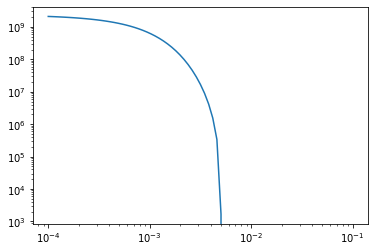

In [39]:
plt.plot(dmrange,rate)
plt.xscale("log")
plt.yscale("log")

In [97]:
dmrange = np.geomspace(1e-4, 1e-1, num=75)
dmrate = lambda x: drde(x, 0.1, 1e-35, tm='Si')
sample = pdf_sampling(dmrate,[1e-4,1e-1],750,1000)

In [98]:
test = lambda a, b, c : a + b + c
print(test(5, 6, 2))
isinstance(dmrate, types.FunctionType)

13


True

In [99]:
sample

array([0.00045728, 0.00026173, 0.000199  , 0.00048163, 0.0004922 ,
       0.00043513, 0.00026621, 0.00064693, 0.00136684, 0.00111336,
       0.00077086, 0.00083415, 0.00027225, 0.0017596 , 0.00076446,
       0.00114343, 0.0013353 , 0.00019959, 0.00108816, 0.00078074,
       0.00024336, 0.0011797 , 0.00041214, 0.00052445, 0.00013609,
       0.00110307, 0.00146756, 0.0009331 , 0.00020941, 0.00295929,
       0.00072687, 0.00040918, 0.00011721, 0.00169959, 0.00168879,
       0.00084823, 0.00089098, 0.00163407, 0.00054973, 0.00077473,
       0.00148998, 0.00076088, 0.00022985, 0.00077081, 0.00018897,
       0.00057208, 0.00018344, 0.00068814, 0.00066788, 0.00181496,
       0.0004375 , 0.0008028 , 0.00152993, 0.00013585, 0.00031643,
       0.00131109, 0.00052268, 0.00033104, 0.00100142, 0.00064272,
       0.00020372, 0.00170478, 0.00201765, 0.00055911, 0.00048598,
       0.00018672, 0.00015016, 0.00032876, 0.00111392, 0.00022079,
       0.0016577 , 0.00055651, 0.00032163, 0.00099297, 0.00254

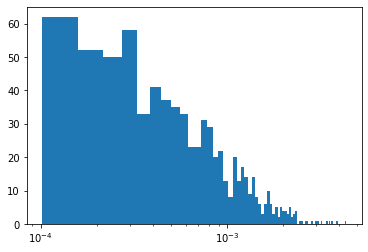

In [100]:
plt.hist(sample,bins=75)
plt.xscale("log")